This notebook does a simplistic approximation of function using Gaussians and Sigmoids

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt




# Network configuration variables
input_size = 1
num_gaussians = 50
num_sigmoids = 0
output_size = 1

In [3]:
class SimpleFNN(nn.Module):
    def __init__(self, num_gaussians,num_sigmoids, output_size):
        super(SimpleFNN, self).__init__()
        self.num_gaussians = num_gaussians
        self.num_sigmoids = num_sigmoids
        self.means = nn.Parameter(torch.randn(num_gaussians))
        self.origins = nn.Parameter(torch.randn(num_sigmoids))
        self.log_sigmas = nn.Parameter(torch.randn(num_gaussians)/4)
        self.scales = nn.Parameter(torch.randn(num_sigmoids)/4)
        self.fc2 = nn.Linear(num_gaussians+num_sigmoids, output_size)
        self.init_weights()
        
    def init_weights(self):
        nn.init.normal_(self.fc2.weight, mean=0, std=1)
        nn.init.normal_(self.fc2.bias, mean=0, std=1)
        self.fc2.weight.data.clamp_(-1, 1)

    def forward(self, x):
        x = x.view(-1, 1)
        mu = self.means.view(1, -1)
        sigma = torch.exp(self.log_sigmas).view(1, -1)
        
        origins = self.origins.view(1, -1)
        scales = torch.exp(self.scales).view(1, -1)

        x_expanded = x.expand(-1, self.num_gaussians)
        gaussians = torch.exp(-0.5 * ((x_expanded - mu) / sigma)**2)
        x_expanded_2 = x.expand(-1, self.num_sigmoids)
        sigmoids = 1/(1+torch.exp(- ((x_expanded_2 - origins) / scales)))
        features = torch.cat([gaussians, sigmoids], dim=1)
        return self.fc2(features)


### Two Gaussian approximation of f(x) = x^2

In [76]:
net = SimpleFNN(num_gaussians=2,num_sigmoids=0,output_size=1)

x_eval = torch.linspace(-1, 1, 100).unsqueeze(1)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

previous_loss = 100
for epoch in range(1000000):
    optimizer.zero_grad()
    y_pred = net(x_eval)
    y_true = x_eval**2
    l1_norm = torch.norm(net.fc2.weight, 1)
    loss = criterion(y_pred, y_true)# + torch.tensor(0.002)*l1_norm
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}")
        print("Amplitudes:", net.fc2.weight)
        current_loss = loss
        previous_loss = loss

Epoch 0, Loss 1.087206
Amplitudes: Parameter containing:
tensor([[0.2070, 0.6204]], requires_grad=True)
Epoch 10000, Loss 0.000045
Amplitudes: Parameter containing:
tensor([[1.3818, 1.9664]], requires_grad=True)
Epoch 20000, Loss 0.000005
Amplitudes: Parameter containing:
tensor([[2.1647, 2.2108]], requires_grad=True)
Epoch 30000, Loss 0.000002
Amplitudes: Parameter containing:
tensor([[2.6468, 2.6480]], requires_grad=True)
Epoch 40000, Loss 0.000001
Amplitudes: Parameter containing:
tensor([[2.8790, 2.8792]], requires_grad=True)
Epoch 50000, Loss 0.000001
Amplitudes: Parameter containing:
tensor([[3.0392, 3.0393]], requires_grad=True)
Epoch 60000, Loss 0.000001
Amplitudes: Parameter containing:
tensor([[3.1635, 3.1635]], requires_grad=True)
Epoch 70000, Loss 0.000001
Amplitudes: Parameter containing:
tensor([[3.2655, 3.2655]], requires_grad=True)
Epoch 80000, Loss 0.000001
Amplitudes: Parameter containing:
tensor([[3.3527, 3.3527]], requires_grad=True)
Epoch 90000, Loss 0.000001
Ampli

KeyboardInterrupt: 

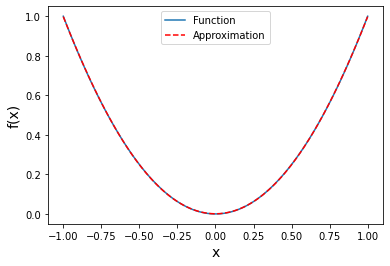

In [77]:
k = 1

plt.plot(k*x_eval, ((k*x_eval)**2+ 0).detach().numpy(),label = 'Function')
plt.plot(k*x_eval, net(k*x_eval).detach().numpy(), 'r--', label = 'Approximation')
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

### Two Sigmoid approximation of f(x) = sqrt(1+x)

In [69]:
net = SimpleFNN(num_gaussians=0,num_sigmoids=2,output_size=1)

x_eval = torch.linspace(-1, 1, 100).unsqueeze(1)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

previous_loss = 100
for epoch in range(100000):
    optimizer.zero_grad()
    y_pred = net(x_eval)
    y_true = torch.sqrt(1+x_eval)
    l1_norm = torch.norm(net.fc2.weight, 1)
    loss = criterion(y_pred, y_true)# + torch.tensor(0.002)*l1_norm
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}")
        print("Amplitudes:", net.fc2.weight)
        current_loss = loss
        previous_loss = loss

Epoch 0, Loss 1.551532
Amplitudes: Parameter containing:
tensor([[0.2137, 0.2550]], requires_grad=True)
Epoch 10000, Loss 0.000296
Amplitudes: Parameter containing:
tensor([[0.9355, 0.8900]], requires_grad=True)
Epoch 20000, Loss 0.000109
Amplitudes: Parameter containing:
tensor([[2.0853, 1.1067]], requires_grad=True)
Epoch 30000, Loss 0.000089
Amplitudes: Parameter containing:
tensor([[2.6761, 1.3321]], requires_grad=True)
Epoch 40000, Loss 0.000082
Amplitudes: Parameter containing:
tensor([[2.9984, 1.4742]], requires_grad=True)
Epoch 50000, Loss 0.000078
Amplitudes: Parameter containing:
tensor([[3.2329, 1.5828]], requires_grad=True)
Epoch 60000, Loss 0.000076
Amplitudes: Parameter containing:
tensor([[3.4208, 1.6722]], requires_grad=True)
Epoch 70000, Loss 0.000074
Amplitudes: Parameter containing:
tensor([[3.5795, 1.7490]], requires_grad=True)
Epoch 80000, Loss 0.000073
Amplitudes: Parameter containing:
tensor([[3.7180, 1.8170]], requires_grad=True)
Epoch 90000, Loss 0.000072
Ampli

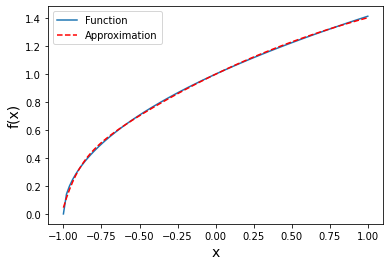

In [71]:
k = 1

plt.plot(k*x_eval, (torch.sqrt(1+k*x_eval)+ 0).detach().numpy(),label = 'Function')
plt.plot(k*x_eval, net(k*x_eval).detach().numpy(), 'r--', label = 'Approximation')
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

In [ ]:
### Two Gaussian approximation of f(x) = sin(2*pi*x)

In [81]:

net = SimpleFNN(num_gaussians=2,num_sigmoids=1,output_size=1)

x_eval = torch.linspace(-1, 1, 100).unsqueeze(1)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

previous_loss = 100
for epoch in range(200000):
    optimizer.zero_grad()
    y_pred = net(x_eval)
    y_true = torch.sin(2*torch.pi*x_eval)
    l1_norm = torch.norm(net.fc2.weight, 1)
    loss = criterion(y_pred, y_true)# + torch.tensor(0.002)*l1_norm
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}")
        print("Amplitudes:", net.fc2.weight)
        current_loss = loss
        previous_loss = loss

Epoch 0, Loss 0.000237
Amplitudes: Parameter containing:
tensor([[ -5.9399,  26.1881, -15.4002]], requires_grad=True)
Epoch 10000, Loss 0.000229
Amplitudes: Parameter containing:
tensor([[ -5.9784,  26.3986, -15.5325]], requires_grad=True)
Epoch 20000, Loss 0.000221
Amplitudes: Parameter containing:
tensor([[ -6.0197,  26.6180, -15.6713]], requires_grad=True)
Epoch 30000, Loss 0.000214
Amplitudes: Parameter containing:
tensor([[ -6.0594,  26.8279, -15.8044]], requires_grad=True)
Epoch 40000, Loss 0.000207
Amplitudes: Parameter containing:
tensor([[ -6.0976,  27.0286, -15.9322]], requires_grad=True)
Epoch 50000, Loss 0.000201
Amplitudes: Parameter containing:
tensor([[ -6.1345,  27.2212, -16.0550]], requires_grad=True)
Epoch 60000, Loss 0.000196
Amplitudes: Parameter containing:
tensor([[ -6.1701,  27.4063, -16.1734]], requires_grad=True)
Epoch 70000, Loss 0.000190
Amplitudes: Parameter containing:
tensor([[ -6.2045,  27.5840, -16.2874]], requires_grad=True)
Epoch 80000, Loss 0.000185
A

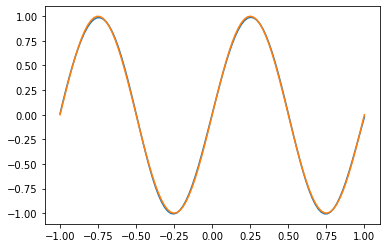

In [82]:
plt.plot(x_eval, net(x_eval).detach().numpy())
plt.plot(x_eval, (torch.sin(2*np.pi*x_eval)+ 0).detach().numpy())

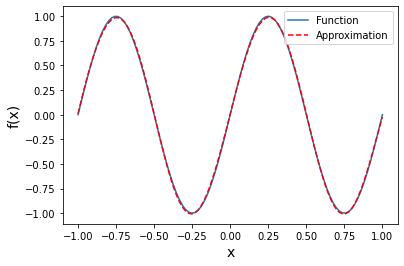

In [84]:
k = 1

plt.plot(k*x_eval, (torch.sin(k*2*np.pi*x_eval)+ 0).detach().numpy(),label = 'Function')
plt.plot(k*x_eval, net(k*x_eval).detach().numpy(), 'r--', label = 'Approximation')
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

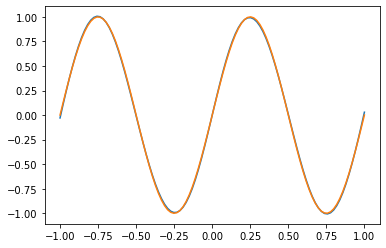

In [88]:
plt.plot(x_eval, net(x_eval).detach().numpy())
plt.plot(x_eval, torch.sin(2*np.pi*x_eval).detach().numpy())

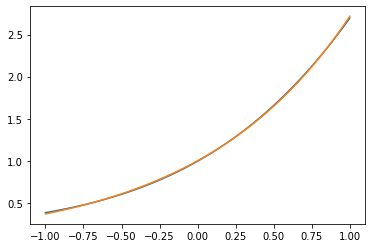

In [36]:
plt.plot(x_eval, net(x_eval).detach().numpy())
plt.plot(x_eval, torch.exp(x_eval).detach().numpy())

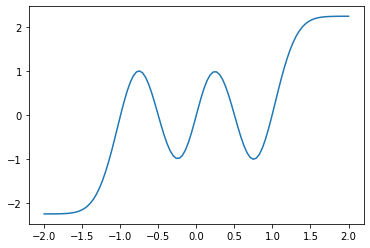

In [90]:
k = 2
plt.plot(k*x_eval, net(k*x_eval).detach().numpy())
#plt.plot(k*x_eval, torch.exp(k*x_eval).detach().numpy())

In [41]:
print_basis_function_sum(net)

NameError: name 'print_basis_function_sum' is not defined

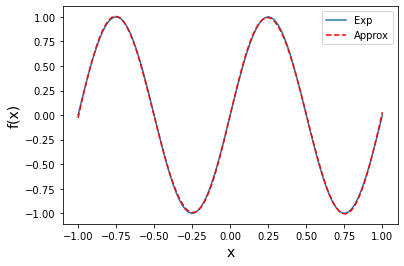

In [86]:
x= x_eval
k = 1
g = -3.2408 * torch.exp(-0.5 * ((x - 0.7568) / 0.2798)**2) +3.2408 * torch.exp(-0.5 * ((x - -0.7567) / 0.2798)**2) +4.5070 *  1/(1+torch.exp(-(x - -0.0000) / 0.1386)) -2.2535

plt.plot(k*x_eval, torch.sin(k*2*np.pi*x_eval).detach().numpy(), label ='Exp')
plt.plot(k*x_eval, g.detach().numpy(), 'r--',label = 'Approx')
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

In [50]:
torch.exp(net.log_sigmas)

tensor([2.0076], grad_fn=<ExpBackward0>)

In [85]:
print_basis_function_sum(net)

Neural Network Output Function:
f(x) = -6.5725 * exp(-0.5 * ((x - 0.7398) / 0.3122)^2) +29.4309 * exp(-0.5 * ((x - 0.7354) / 1.0480)^2) -17.4881 * sigmoid((x - -0.4796) / 0.1896) -6.4055


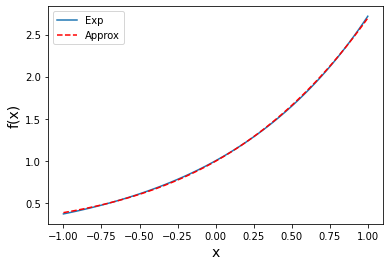

In [56]:
g = 18.8961 * torch.exp(-0.5 * ((x_eval - 5.0295) / 2.0076)**2) +0.1754

plt.plot(k*x_eval, torch.exp(k*x_eval).detach().numpy(), label ='Exp')
plt.plot(k*x_eval, g.detach().numpy(), 'r--',label = 'Approx')
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

In [42]:
def print_basis_function_sum(net):
    with torch.no_grad():
        sigma = torch.exp(net.log_sigmas).view(-1)
        mu = net.means.view(-1)
        amp_gauss = net.fc2.weight[0, :net.num_gaussians]

        scales = torch.exp(net.scales).view(-1)
        origins = net.origins.view(-1)
        amp_sigm = net.fc2.weight[0, net.num_gaussians:]

        bias = net.fc2.bias.item()

    print("Neural Network Output Function:")
    print("f(x) = ", end="")
    
    # Gaussian terms
    for i in range(net.num_gaussians):
        print(f"{amp_gauss[i].item():+.4f} * exp(-0.5 * ((x - {mu[i].item():.4f}) / {sigma[i].item():.4f})^2)", end=" ")

    # Sigmoid terms
    for i in range(net.num_sigmoids):
        print(f"{amp_sigm[i].item():+.4f} * sigmoid((x - {origins[i].item():.4f}) / {scales[i].item():.4f})", end=" ")

    # Bias term
    print(f"{bias:+.4f}")

In [72]:
print_basis_function_sum(net)

Neural Network Output Function:
f(x) = +4.7400 * sigmoid((x - -2.0218) / 1.3036) +2.3384 * sigmoid((x - -1.1713) / 0.0890) -5.2497


In [44]:
net(torch.tensor([0, 1]))

tensor([[0.9948],
        [2.6963]], grad_fn=<AddmmBackward0>)

In [24]:
np.exp(2)

7.38905609893065

In [153]:
net.fc2.weight = torch.nn.Parameter(torch.tensor([[ 0, -0.7888,  0.7976, 0, 0]]))

In [197]:
net.fc2.bias

Parameter containing:
tensor([-1.8851], requires_grad=True)

In [196]:
net.means

Parameter containing:
tensor([ 0.7558, -0.2474], requires_grad=True)

In [ ]:
nn.Parameter(torch.randn(num_gaussians))